# i. Perkenalan
Nama: Timothy Batch: FTDS-011 Dataset: First GOP Debate Twitter Sentiment Objective: Buatlah model sentiment analysis

# ii. Import Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

%matplotlib inline

# iii. Data Loading
Data diambil dari dataset kaggle, dataset berisikan sekitar 10000 tweet saat Debat GOP di Ohio

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Dataset/Sentiment.csv')


# iv. Exploratory Data Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

In [ ]:
data.describe()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
count,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04
mean,6936.000000,0.855689,0.927304,0.756936,0.782801,45.803331,6.296058e+17
std,4004.357127,0.241388,0.141696,0.217682,0.258215,153.981724,9.611863e+13
min,1.000000,0.222200,0.333300,0.186000,0.222200,0.000000,6.294531e+17
25%,3468.500000,0.674200,1.000000,0.651700,0.641300,0.000000,6.294861e+17
50%,6936.000000,1.000000,1.000000,0.681300,1.000000,2.000000,6.296726e+17
75%,10403.500000,1.000000,1.000000,1.000000,1.000000,44.000000,6.296882e+17
max,13871.000000,1.000000,1.000000,1.000000,1.000000,4965.000000,6.297017e+17


In [ ]:
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [ ]:
data['sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

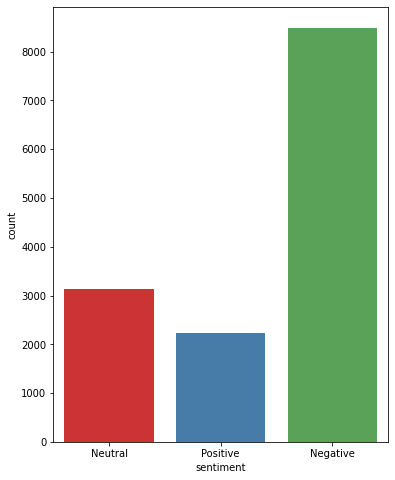

In [ ]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="sentiment", data=data, palette="Set1")
plt.show()

Sentiment Negative melebihi jumlah sentiment positive, kurang lebih 4x lipat sentiment positive

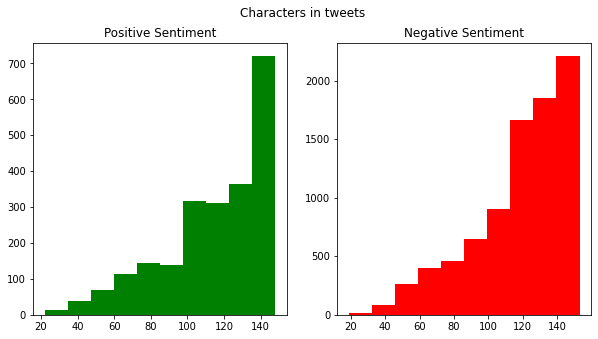

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data[data['sentiment']=='Positive']['text'].str.len() #menghitung jumlah karakter di kolom sentiment
ax1.hist(tweet_len,color='green')
ax1.set_title('Positive Sentiment')
tweet_len=data[data['sentiment']=='Negative']['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Negative Sentiment')
fig.suptitle('Characters in tweets')
plt.show()

Jumlah karakter tweet negative ada di angka 110-150 karakter sedangkan tweet positive paling banyak di 140 karakter

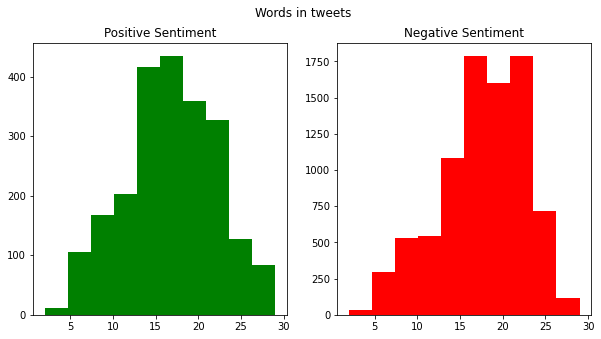

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data[data['sentiment']=='Positive']['text'].str.split().map(lambda x: len(x)) #menghitung jumlah kata di kolom sentiment
ax1.hist(tweet_len,color='green')
ax1.set_title('Positive Sentiment')
tweet_len=data[data['sentiment']=='Negative']['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Negative Sentiment')
fig.suptitle('Words in tweets')
plt.show()

Tweet positive terbanyak ada di 15-20 kata sedangkan tweet negative terbanyak ada di 15-25 kata

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

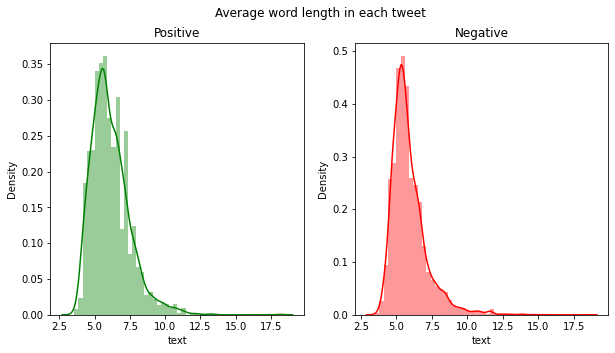

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=data[data['sentiment']=='Positive']['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Positive')
word=data[data['sentiment']=='Negative']['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative')
fig.suptitle('Average word length in each tweet')

Density antara tweet positif dengan negatif kurang lebih sama

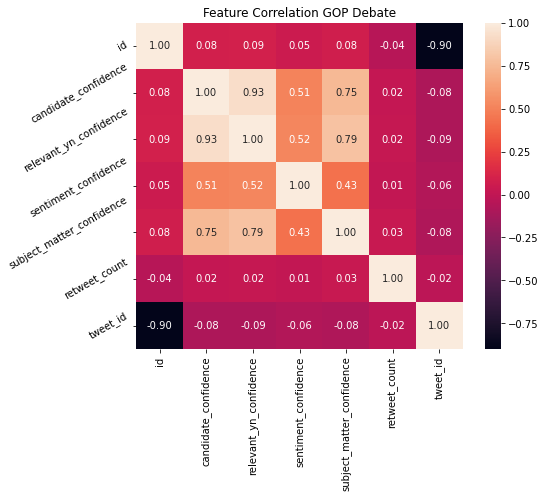

In [ ]:
correlation = data.corr()
plt.figure(figsize=(8,6))
plt.title('Feature Correlation GOP Debate')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

Fitur yang memiliki korelasi tinggi dengan sentiment confidence adalah candidate confidence, relevant confidence, serta subject matter confidence

## EDA Summary
Dalam debat twitter tersebut dapat disimpulkan bahwa lebih banyak sentiment negative dibandingkan sentiment positive hal ini disebabkan oleh candidate yang dibahas dalam tweet serta subjek debat pada saat itu, jadi saya asumsikan kandidat kandidat dalam debat tersebut menjawab dengan pernyataan yang cukup kontroversial sehingga menimbulkan banyaknya cuitan atau tweet negative dari pada audiencenya, sehingga menyebabkan jumlah tweet dengan negative sentiment jauh lebih banyak (bahkan sampai 4x lipat) dari tweet positive, dan dapat saya asumsikan banyaknya tweet negative karena tweet dari audience bersifat menjatuhkan kandidat.

# v. Data Preprocessing

## Text Preprocessing

Mengambil kolom yang relevan

In [ ]:
data = data[['text','sentiment']]

Mengambil sentiment positive dan negative saja, mengubah values menjadi lowercase dan sesuai standard ASCII, menetapkan max_features sebanyak 2000 dan menggunakan tokenizer untuk mengubah menjadi vector dan mengubah text menjadi sequences

In [ ]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ') #menghilangkan RT karena tidak relevan
    
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4472
16986


## Splitting Dataset
Menggunakan dummies feature sentiment sebagai target atau (y)

In [ ]:
y = pd.get_dummies(data['sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8583, 28) (8583, 2)
(2146, 28) (2146, 2)


# vi. Model Definition
Membuat sentiment analysis dengan model Recurrent Neural Network LSTM, disini saya menggunakan LSTM karena LSTM adalah model yang cocok untuk klasifikasi, memproses, dan membuat prediksi berdasarkan data time series, Embedded menjadi vector dengan dimensi 128, mengubah vector sequence menjadi ukuran 196, dropout 0.2 untuk menghindari overfitting

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 28, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32 # number of samples processed before the model is updated
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 2)

Epoch 1/5
269/269 - 43s - loss: 0.4233 - accuracy: 0.8236 - 43s/epoch - 158ms/step
Epoch 2/5
269/269 - 41s - loss: 0.3145 - accuracy: 0.8675 - 41s/epoch - 151ms/step
Epoch 3/5
269/269 - 38s - loss: 0.2777 - accuracy: 0.8863 - 38s/epoch - 141ms/step
Epoch 4/5
269/269 - 38s - loss: 0.2507 - accuracy: 0.8981 - 38s/epoch - 140ms/step
Epoch 5/5
269/269 - 38s - loss: 0.2241 - accuracy: 0.9084 - 38s/epoch - 141ms/step


In [ ]:
validation_size = 1500 #ukuran validation data

X_validate = X_test[-validation_size:]
y_validate = y_test[-validation_size:]
X_test = X_test[:-validation_size]
y_test = y_test[:-validation_size]
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

21/21 - 1s - loss: 0.4623 - accuracy: 0.8390 - 782ms/epoch - 37ms/step
score: 0.46
acc: 0.84


Melalui LSTM didapatkan accuracy score sebesar 84% dan skor dari validasi sebesar 41% jadi walaupun tingkat keakuratan prediksi cukup tinggi namun dikarenakan ukuran data validasi yang besar

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(y_validate[x]):
        if np.argmax(y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 292ms/epoch - 292ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 3

Tingkat akurasi prediksi sentiment negative lebih besar, hal ini disebabkan frekuensi sentiment negative selama kampanye sehingga model lebih akurat dalam memprediksi sentiment negatif

## Model Improvement using Bi-Directional LSTM
Bidirectional LSTM menambahkan satu layer lagi sehingga jalur proses kerja menjadi dua arah (bolak-balik) dan Bidirectional LSTM lebih cocok untuk prediksi NLP text

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 28, 128)           256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 28, 128)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 392)              509600    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 2)                 786       
                                                                 
Total params: 766,386
Trainable params: 766,386
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 2)

Epoch 1/5
269/269 - 84s - loss: 0.4242 - accuracy: 0.8215 - 84s/epoch - 311ms/step
Epoch 2/5
269/269 - 79s - loss: 0.3090 - accuracy: 0.8734 - 79s/epoch - 293ms/step
Epoch 3/5
269/269 - 77s - loss: 0.2750 - accuracy: 0.8895 - 77s/epoch - 286ms/step
Epoch 4/5
269/269 - 77s - loss: 0.2456 - accuracy: 0.8988 - 77s/epoch - 285ms/step
Epoch 5/5
269/269 - 78s - loss: 0.2189 - accuracy: 0.9089 - 78s/epoch - 289ms/step


# vii. Model Saving

Membuat pipeline dengan KerasRegressor

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
clf = KerasRegressor(build_fn=model, verbose=0)
pipeline = Pipeline([
    ('clf',clf)
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
import pickle
with open("pipeline.pkl", "wb") as pipe_file:
  pickle.dump(pipeline, pipe_file)

INFO:tensorflow:Assets written to: ram://c5f0953c-8ee0-4644-88c9-39380a252693/assets


In [ ]:
model.save("lstm_sentiment_analysis")

INFO:tensorflow:Assets written to: lstm_sentiment_analysis/assets


INFO:tensorflow:Assets written to: lstm_sentiment_analysis/assets


# viii. Model Inference

In [ ]:
twt = ['He will not get my vote']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  32  82  19  75  53 203]]
1/1 - 0s - 494ms/epoch - 494ms/step
negative


# ix. Decision Making
Model LSTM menurut saya cukup efektif dalam memprediksi cuitan yang negatif, namun untuk memprediksi cuitan yang positif menurut saya model ini perlu mengambil contoh data cuitan positif lebih banyak lagi, mungkin kalau distribusi data sentiment terdistribusi normal maka model ini dapat menjadi model yang lebih baik dalam memprediksi cuitan positif, dan seharusnya model improvement BiDirectional LSTM menyebabkan perbedaan yang cukup signifikan, namun keterbatasan saya dalam pembuatan atau pengimplementasi model machine learning membuat model ini masih jauh dari sempurna

# References
https://www.kaggle.com/code/purvasingh/eda-and-sentiment-analysis-of-joe-biden-tweets/notebook

https://www.kaggle.com/code/ngyptr/lstm-sentiment-analysis-keras/notebook